# Completing the same examples without PyMC

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.style.use("ggplot")
import scipy.stats as stats
plt.rcParams['figure.figsize'] = [11, 6]

### First load in the data and plot it to visualise it in a plot to become familiar with it.

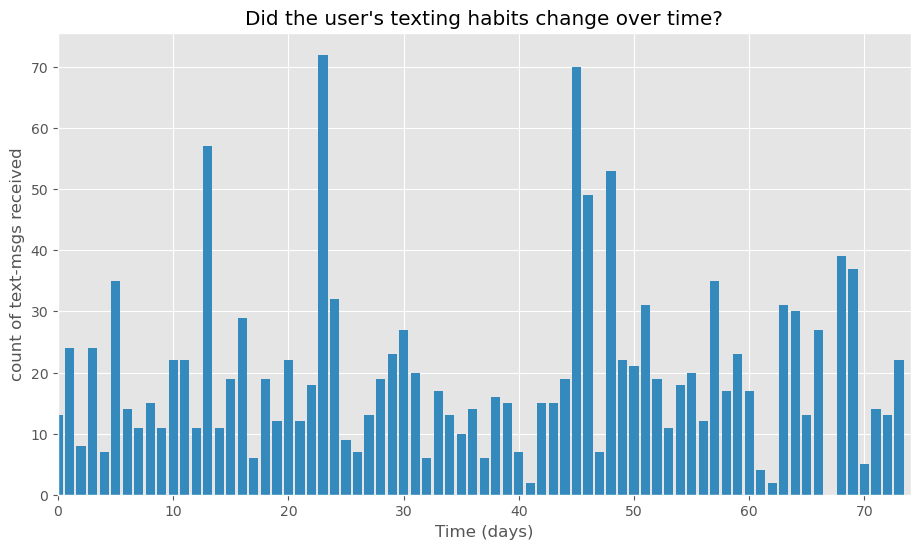

In [2]:
count_data = np.loadtxt("txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

### Now to begin

### The version with PyMC.

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 13 seconds.


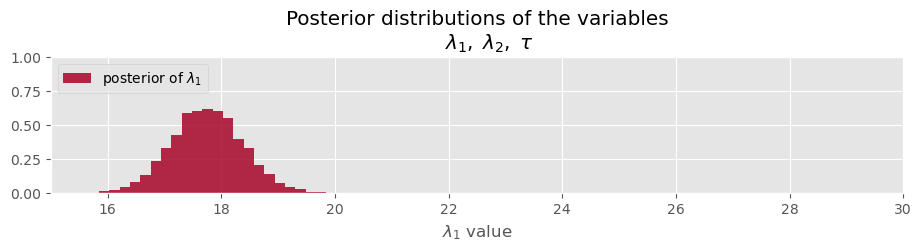

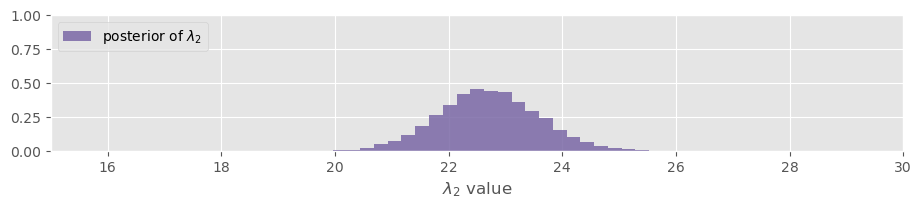

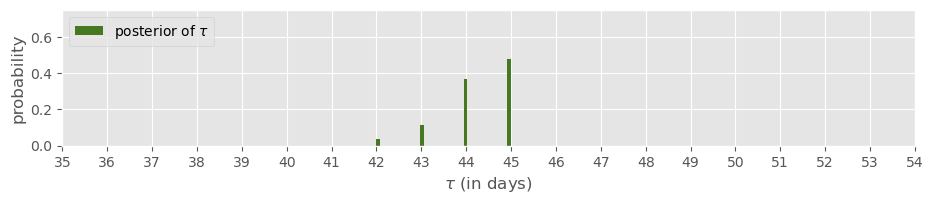

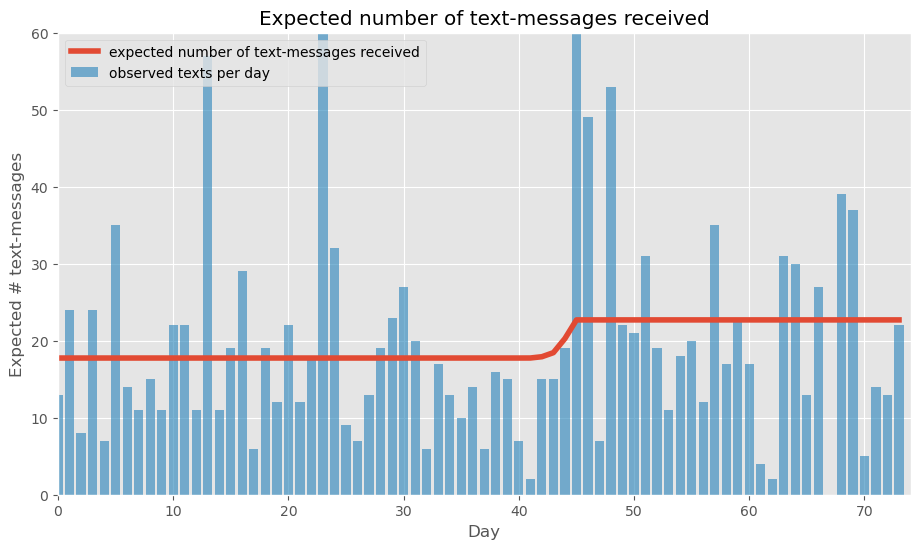

In [3]:
import pymc as pm

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper= n_count_data - 1)
    
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

    observation = pm.Poisson("obs", lambda_, observed=count_data)

    step = pm.Metropolis()
    trace = pm.sample(10000, tune=20000, step=step, return_inferencedata=False)
    
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")
plt.show()

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")
plt.show()

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");
plt.show()

N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    ix = day < tau_samples
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

### The version without PyMC.

Well first the first thing that we can tackle is the value of alpha as this is just a constant, however the code still needs to be adjusted as we no longer have PyMC. the new value can be code below.

In [4]:
my_alpha = 1.0/np.mean(count_data)

The next steps a a little bit more tricky. We now have to encode up functions for the various distributions that were implemented with the use of PyMC. Nmaely, we need to cretae function for the following:
* The Exponential Distribution
* The Discrete Uniform Distribution
* The Poisson Distribution
However, this is fairly simple to to with a little knowledge of statistics or even just a quick Google search. Thus we can code up the a general version for the aforementioned distributions as (we will need to make sure to select paramters as close to that of those used in PyMC):

In [5]:
import math
def my_exponential(x,a,b,c,d):
    power = (b*x) + c
    return (a*np.exp(power)) + d

def my_dicrete_uniform_distribution(x, a, b):
    if x < a or x > b:
        return 0
    else:
        f = 1/(b-a+1)
        return f

def my_poisson_distribution(x, lam):
    part_one = lam**x
    part_two = np.exp(-lam)
    part_three = math.factorial(x)
    return (part_one*part_two)/part_three

Well now that we have a general form for the disrtibutions what parameters should we use for each of them? The esponential distribution is simple. By looking at the PyMC documentation we find that this is expressesd as f(x|$\lambda$) = ${ \lambda e^{-\lambda x} }$, where in our case the $\lambda$ parameter as before is just the value of alpha.

What does this look like? well lets plot the distrbution.

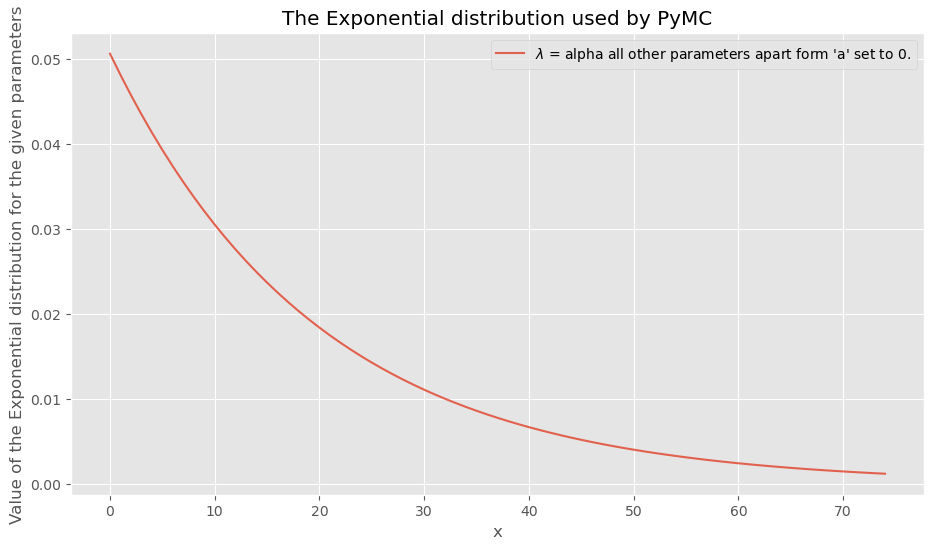

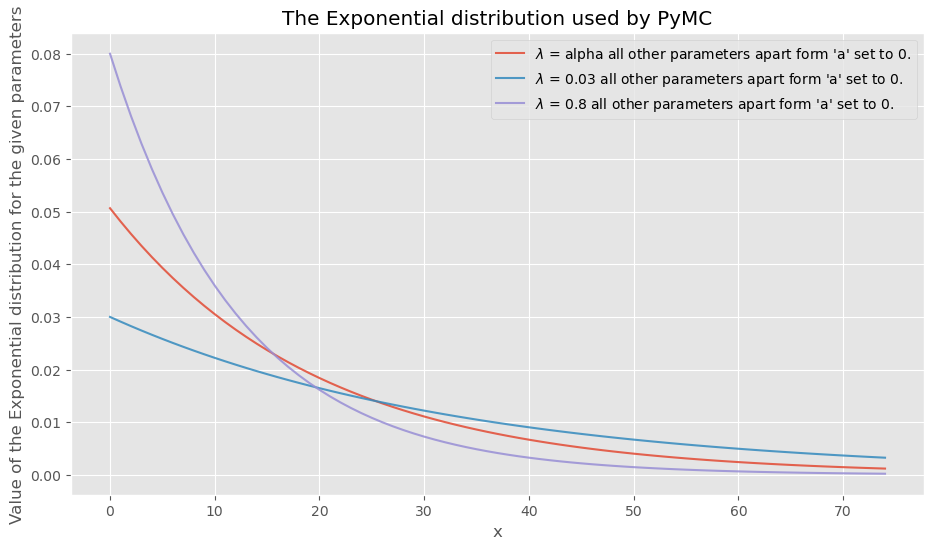

In [6]:
exampleweeks = np.linspace(0, n_count_data, n_count_data+1)
ax.set_autoscaley_on(False)
ax = plt.subplot()
plt.plot(exampleweeks, my_exponential(exampleweeks,my_alpha,-my_alpha,0,0), alpha=0.85, label = f"$\lambda$ = alpha all other parameters apart form 'a' set to 0.")
plt.xlabel("x")
plt.ylabel("Value of the Exponential distribution for the given parameters")
plt.title("The Exponential distribution used by PyMC")
plt.legend()
plt.show()

ax = plt.subplot()
plt.plot(exampleweeks, my_exponential(exampleweeks,my_alpha,-my_alpha,0,0), alpha=0.85, label = f"$\lambda$ = alpha all other parameters apart form 'a' set to 0.")
plt.plot(exampleweeks, my_exponential(exampleweeks,0.03,-0.03,0,0), alpha=0.85, label = f"$\lambda$ = 0.03 all other parameters apart form 'a' set to 0.")
plt.plot(exampleweeks, my_exponential(exampleweeks,0.08,-0.08,0,0), alpha=0.85, label = f"$\lambda$ = 0.8 all other parameters apart form 'a' set to 0.")
plt.xlabel("x")
plt.ylabel("Value of the Exponential distribution for the given parameters")
plt.title("The Exponential distribution used by PyMC")
plt.legend()

Here we can see that the value we set $\lambda$ to be has a large impact on what the distribution looks like. Thus, if the value of alpha is different then this will drastically change the results. However, the value of the priors shouldn't impact the accuracy of the result much and this is true for the caase of PyMC. The difficulty now arrises, how can we make sure to reduce the affect of poorly chosen priors? 

In [7]:
print("The alpha used when using PyMC:", alpha)
print("The alpha used without using PyMC:", my_alpha)
print("The difference between the two alpha parameters:", alpha - my_alpha)

The alpha used when using PyMC: 0.05065023956194388
The alpha used without using PyMC: 0.05065023956194388
The difference between the two alpha parameters: 0.0


Now lets look at the Tau parameter. we can simply use the same upper and lower inputs as previous.

In [8]:
#my_tau = my_dicrete_uniform_distribution(0, n_count_data)

Now lets deal with the switch function for lamda and lets tackle what was previously defined as the 'observation'. This is where we assign our prior distribution to be a Poisson distribution.

In [9]:
def condition_obs_probability(x, my_lambda_1, my_lambda_2, my_tau):
    """input: observation x, parameters A (tau, lambda1, lambda2) 
       output: probability of that observation given those parameters: P(X | A)"""
    p_list = []
    for i, obser in enumerate(x):
        if i < my_tau:
            p = my_poisson_distribution(obser, my_lambda_1)
        else: 
            p = my_poisson_distribution(obser, my_lambda_2)
        p_list.append(p)
    return np.prod(p_list)

def bayesian_rule_prob(x, my_lambda_1, my_lambda_2, my_tau):
    P_x_a = condition_obs_probability(x, my_lambda_1, my_lambda_2, my_tau)
    p_lambda1 = my_exponential(my_lambda_1, 1, -my_alpha, 0, 0)
    p_lambda2 = my_exponential(my_lambda_2, 1, -my_alpha, 0, 0)
    p_tau = my_dicrete_uniform_distribution(my_tau, 0, n_count_data)

    prob = p_lambda1* p_lambda2* p_tau* P_x_a
    return prob

In [10]:
# n_count_data = 10
# count_data = count_data[:n_count_data]
p_best = 0
#lam1 = 18, lam2 = 23
best_lambda1 = 18 #my_alpha
best_lambda2 = 23 #my_alpha
best_tau = n_count_data/2

lambda_step_size = 0.8
tau_step_size = n_count_data/70
n_tune = 20000
n_samples = 10000

my_lambda_1_sample = np.mean(count_data) 
my_lambda_2_sample = np.mean(count_data) 
my_tau_sample = n_count_data/2
accepted_list = []

for i in range(n_tune + n_samples):
    my_lambda_1_sample_new = my_lambda_1_sample * (1 + (np.random.rand()-1/2) * lambda_step_size)
    my_lambda_2_sample_new = my_lambda_2_sample * (1 + (np.random.rand()-1/2) * lambda_step_size)
    my_tau_sample_new = my_tau_sample + (np.random.rand()-1/2) * tau_step_size

    acceptance_ratio = bayesian_rule_prob(count_data, my_lambda_1_sample_new, my_lambda_2_sample_new, my_tau_sample_new) / bayesian_rule_prob(count_data, my_lambda_1_sample, my_lambda_2_sample, my_tau_sample)

    if np.random.rand() <= acceptance_ratio:
        my_lambda_1_sample = my_lambda_1_sample_new
        my_lambda_2_sample = my_lambda_2_sample_new
        my_tau_sample = my_tau_sample_new
        
    if i >= n_tune:
        accepted_list.append([my_lambda_1_sample, my_lambda_2_sample, my_tau_sample])

    if i % 5000 == 0:
        print(i, p_best, best_lambda1, best_lambda2, best_tau)
        print("    lambda 1:", my_lambda_1_sample, "lambda 2", my_lambda_2_sample, "tau", my_tau_sample) 

    p = bayesian_rule_prob(count_data, my_lambda_1_sample, my_lambda_2_sample, my_tau_sample)
    if p > p_best:
        p_best = p
        best_lambda1 = my_lambda_1_sample
        best_lambda2 = my_lambda_2_sample
        best_tau = my_tau_sample
    
print(p_best, best_lambda1, best_lambda2, best_tau)



0 0 18 23 37.0
    lambda 1: 19.743243243243242 lambda 2 19.743243243243242 tau 37.0


/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_10893/100478048.py:16: DeprecationWarning: Using factorial() with floats is deprecated
  part_three = math.factorial(x)


5000 1.5999445508823575e-212 18.36282569741353 22.802053781132567 43.02409610907583
    lambda 1: 17.71427098199306 lambda 2 21.740929838095383 tau 43.134362058982106
10000 3.463211416757756e-212 17.898279061721038 22.899916759715925 44.129181305575784
    lambda 1: 17.262941374862393 lambda 2 22.37891289361853 tau 44.17668211237723
15000 3.4851207016135707e-212 17.759013767702026 22.55627809310164 44.452095753737986
    lambda 1: 17.439541483964014 lambda 2 22.981185139272785 tau 43.53167618817685
20000 3.4851207016135707e-212 17.759013767702026 22.55627809310164 44.452095753737986
    lambda 1: 17.80964664994461 lambda 2 23.626896793310344 tau 43.149962098807116
25000 3.4851207016135707e-212 17.759013767702026 22.55627809310164 44.452095753737986
    lambda 1: 16.604979377464712 lambda 2 22.00819490702194 tau 43.70539400853958
3.58136155132941e-212 17.691985599779624 22.880230318890188 44.417435842298985


Lets plot the posterior distributions and see how similar they look to those created with the use of PyMC. 

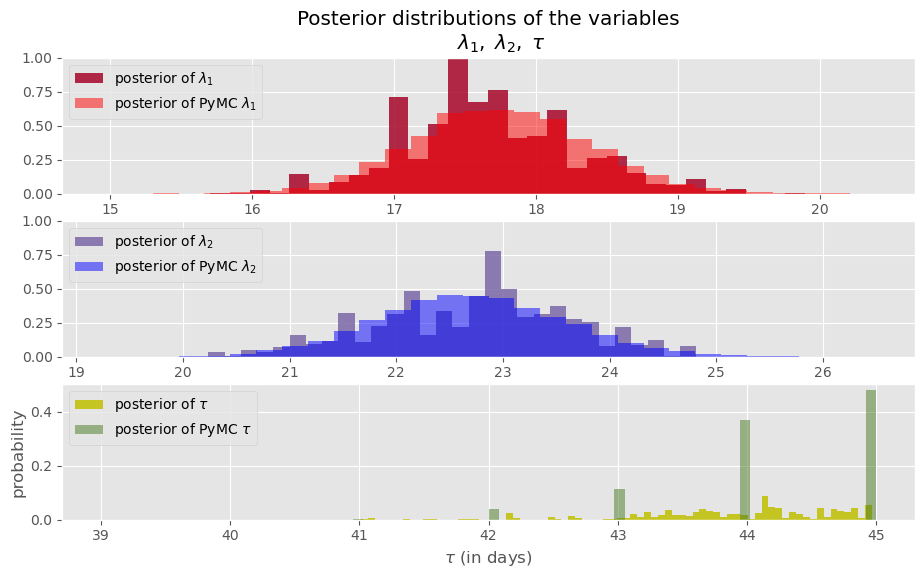

In [11]:
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

acceptedlistnp = np.array(accepted_list)

plt.hist(acceptedlistnp[:,0], histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.5,
         label="posterior of PyMC $\lambda_1$", color="r", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlabel("$\lambda_1$ value")



ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(acceptedlistnp[:,1], histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)

plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.5,
         label="posterior of PyMC $\lambda_2$", color="b", density=True)
plt.legend(loc="upper left")
plt.xlabel("$\lambda_2$ value")



plt.subplot(313)
w = 1.0 / acceptedlistnp[:,2].shape[0] * np.ones_like(acceptedlistnp[:,2])
plt.hist(acceptedlistnp[:,2], bins=n_count_data, alpha=0.85,
         label=r"posterior of $\tau$",
         color="y", weights=w, rwidth=2.)

wid = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=0.5,
         label=r"posterior of PyMC $\tau$",
         color="#467821", weights=wid, rwidth=2.)
# plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

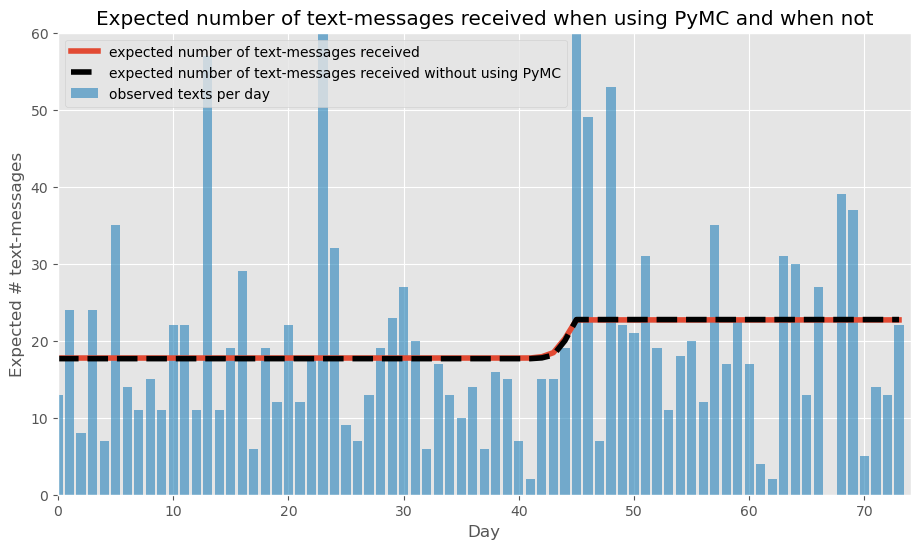

In [12]:
N = np.shape(acceptedlistnp)[0]

my_expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    ix = day < acceptedlistnp[:,2]
    my_expected_texts_per_day[day] = (acceptedlistnp[:,0][ix].sum()
                                   + acceptedlistnp[:,1][~ix].sum()) / N

plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.plot(range(n_count_data), my_expected_texts_per_day, lw=4, color="k", linestyle = '--',
         label="expected number of text-messages received without using PyMC")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received when using PyMC and when not")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");